# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb
from torch.optim.lr_scheduler import StepLR

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(train_set))
val_set = Subset(train_set, I[:val_size])
train_set = Subset(train_set, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, data_loader, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (data, targets) in tqdm(data_loader, desc=f'Training epoch {epoch}', leave=True):
        data , targets = data.to(device), targets.to(device)
        opt.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    with torch.no_grad():
        for (data, targets) in tqdm(dl, desc='Evaluating', leave=False):
            data = data.to(device)
            preds = torch.argmax(model(data), dim=1)
            gts.append(targets)
            predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accuracies = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accuracies)} @ epoch {np.argmax(accuracies)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [ ]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 100
lr = 0.01
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size, num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, train_loader, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, val_loader, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, test_loader, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
# IL mio codice inizia qui
from sklearn.metrics import accuracy_score, classification_report

def train_per_epoch(model, train_loader, optimizer, device):

    model.train()
    losses = []
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return np.mean(losses)


def evaluate(model, test_loader, device='cpu'):

    model.eval()
    predictions = []
    gts = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            output = model(data)
            predictions.append(torch.argmax(output, dim=1).detach().cpu().numpy())
            gts.append(targets.numpy())

    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

def plot_loss_and_accuracy(losses, accuracies):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Average Training Loss per Epoch")
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Validation Accuracy")

# Funzione per valutare i gradienti
def check_gradient(model, data, criterion, device):
    imgs, targets = data
    imgs, targets = imgs.to(device), targets.to(device)

    model.zero_grad()
    output = model(imgs)
    loss = criterion(output, targets)
    loss.backward()

    grad_weights = {}
    grad_biases = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            if 'weight' in name:
                grad_weights[name] = param.grad.norm().item()
            elif 'bias' in name:
                grad_biases[name] = param.grad.norm().item()
    
    sorted_weights = sorted(grad_weights.keys())
    sorted_biases = sorted(grad_biases.keys())

    weight_norms = [grad_weights[layer] for layer in sorted_weights]
    bias_norms = [grad_biases[layer] for layer in sorted_biases]

    plt.figure(figsize=(16, 8))
    plt.bar(range(len(weight_norms)), weight_norms, color='blue', label = 'weights')
    plt.bar(range(len(bias_norms)), bias_norms, color='orange', label = 'biases', alpha=0.5)
    plt.xlabel('Layer')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norms per Layer')
    plt.legend()

    wandb.log({'Weight_norms': wandb.Image(plt)})
    

In [ ]:
# Semplice MLP con batch norm opzionale

class MyMLP(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size, bn=False):
        super().__init__()

        self.layers = nn.Sequential()
        current_size = input_size

        for h in hidden_sizes:
            self.layers.append(nn.Linear(current_size, h))
            if bn:
                self.layers.append(nn.BatchNorm1d(h))
            self.layers.append(nn.ReLU())
            current_size = h

        self.layers.append(nn.Linear(current_size, output_size))

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.layers(x)
        return x
            

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [4]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, hidden_size, bn):
        super().__init__()

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)

        if bn:
            self.layers = nn.Sequential(
                self.fc1,
                self.bn,
                nn.ReLU(),
                self.fc2,
                self.bn,
                nn.ReLU()
            )
        else:
            self.layers = nn.Sequential(
                self.fc1,
                nn.ReLU(),
                self.fc2,
                nn.ReLU()
            )
        
    def forward(self, x):
        residual = x
        x = self.layers(x)
        x = x + residual
        return x


class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_res_blocks, num_outputs, bn=False):
        super().__init__()

        self.res_blocks = []
        self.input_layer = nn.Linear(input_size, hidden_size)

        
        for _ in range(num_res_blocks):
            self.res_blocks.append(ResidualMLPBlock(hidden_size, bn))

        self.output_layer = nn.Linear(hidden_size, num_outputs)

        self.layers = nn.Sequential(
            self.input_layer,
            nn.BatchNorm1d(hidden_size) if bn else nn.Identity(),
            nn.ReLU(),
            *self.res_blocks,
            self.output_layer  
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.layers(x)     
  

Epoch: 1 Loss: 0.4022797904432277
Validation Accuracy: 0.9101
Epoch: 2 Loss: 0.27879515638493974
Validation Accuracy: 0.9172
Epoch: 3 Loss: 0.25678208583246565
Validation Accuracy: 0.9094
Epoch: 4 Loss: 0.253983285394795
Validation Accuracy: 0.9132
Epoch: 5 Loss: 0.24439650206157312
Validation Accuracy: 0.9256
Epoch: 6 Loss: 0.24182087650565465
Validation Accuracy: 0.9178
Epoch: 7 Loss: 0.23702237691106204
Validation Accuracy: 0.9036
Epoch: 8 Loss: 0.22853987387445807
Validation Accuracy: 0.9204
Epoch: 9 Loss: 0.22872662374897457
Validation Accuracy: 0.9212
Epoch: 10 Loss: 0.2260734491274142
Validation Accuracy: 0.9266
Epoch: 11 Loss: 0.1558438260191599
Validation Accuracy: 0.938
Epoch: 12 Loss: 0.14292854458198448
Validation Accuracy: 0.9386
Epoch: 13 Loss: 0.13894886070447962
Validation Accuracy: 0.9381
Epoch: 14 Loss: 0.13536389822216557
Validation Accuracy: 0.939
Epoch: 15 Loss: 0.1324062737733926
Validation Accuracy: 0.9391
Epoch: 16 Loss: 0.1301338990555976
Validation Accuracy: 0

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_loss,█▅▄▄▄▄▄▄▄▄▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▂▄▂▃▅▄▁▄▄▅██████████
epoch,20
training_loss,0.12218
validation_accuracy,0.9403


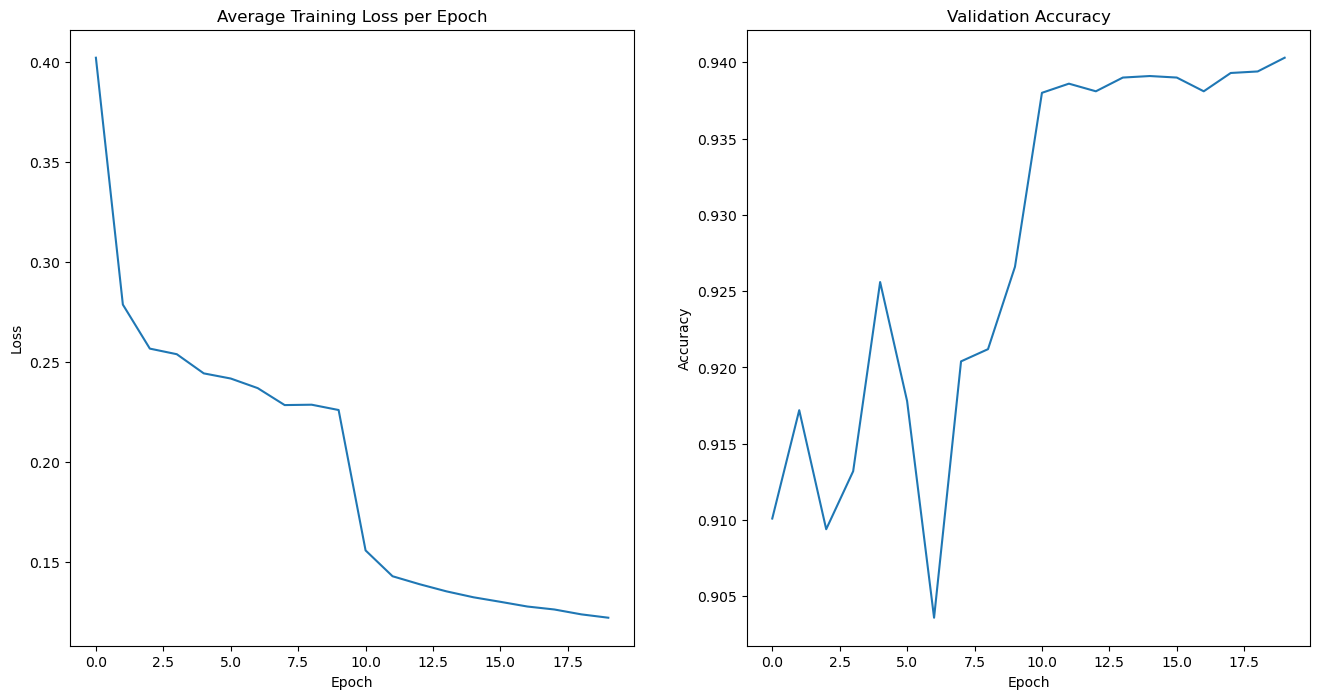

In [ ]:
# Pipeline di training e evaluation

# Dati
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Caricamento del dataset MNIST
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# Split in train e validation
val_size = 10000
I = np.random.permutation(len(train_set))
val_set = Subset(train_set, I[:val_size])
train_set = Subset(train_set, I[val_size:])

# Device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Iperparametri
epochs = 20
batch_size = 64
learning_rate = 0.01 

# DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Iperparametri architetturali
input_size = 28*28
hidden_size = 64
output_size = 10
depth = 31 # Number of hidden layers excluding output layer
model_name = 'ResidualMLP'  # 'MLP' or 'ResidualMLP'

# Iperparametri per ResidualMLP
if model_name == 'ResidualMLP':
    num_res_blocks = 15 # depth = num_res_blocks * 2 + 2
    res_depth = (num_res_blocks * 2) + 2
    

# Modello
if model_name == 'MLP':
    model = MyMLP(input_size, [hidden_size] *depth, output_size, bn=True).to(device)
    wandb.init(project='Lab1-DLA', name= f'MLP_MNIST_width_{hidden_size}_depth_{depth + 1}_bn')
    #wandb.init(project='Lab1-DLA', name=f'MLP_MNIST_gradients_width_{hidden_size}_depth_{depth}')
    #wandb.watch(model, log='gradients', log_freq=100)
elif model_name == 'ResidualMLP':
    model = ResidualMLP(input_size, hidden_size, num_res_blocks, output_size, bn=False).to(device)
    wandb.init(project='Lab1-DLA', group='ResidualMLP_depth_study' , name=f'Residual_MLP_MNIST_width_{hidden_size}_depth_{res_depth}')
else:
    raise ValueError(f'Unknown model name: {model_name}')


# Ottimizzatore e scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer=optimizer, step_size= 10, gamma=0.1)  # Reduce LR every 5 epochs

# Training e evaluation
losses = []
accuracies = []

for epoch in range(epochs):
    losses.append(train_per_epoch(model, train_loader, optimizer, device))
    print(f'Epoch: {epoch+1} Loss: {losses[-1]}')
    if scheduler is not None:
        scheduler.step()
    accuracies.append(evaluate(model, val_loader, device=device)[0])
    print(f'Validation Accuracy: {accuracies[-1]}')
    wandb.log({
        'epoch': epoch + 1,
        'training_loss': losses[-1],
        'validation_accuracy': accuracies[-1]
    })

# Plot di training loss e validation accuracy

plot_loss_and_accuracy(losses, accuracies)

# Valutazione finale sul test set
test_accuracy, test_report = evaluate(model, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy}')

wandb.finish()



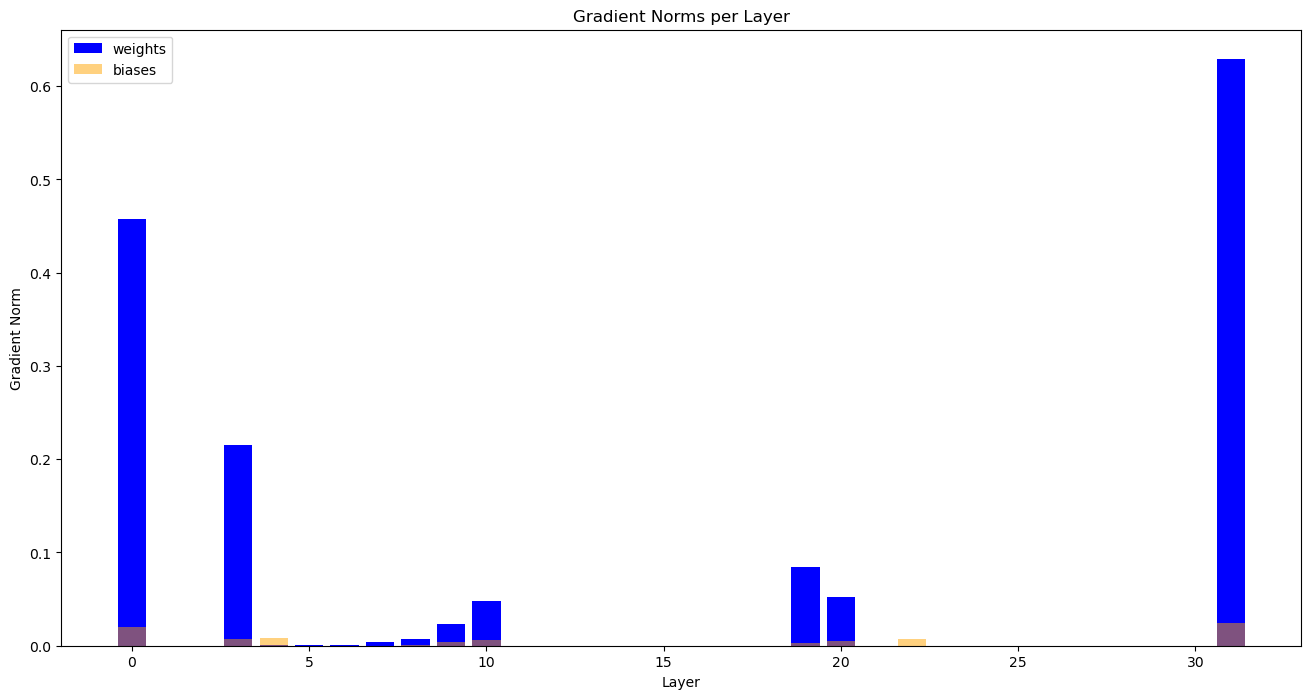

In [ ]:
# Valutazione dei gradienti
wandb.init(project='Lab1-DLA', name='ResMLP_MNIST_gradients_32layers')
data = next(iter(train_loader))
criterion = F.cross_entropy
check_gradient(model, data, criterion, device)

wandb.finish()


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
from torchvision.datasets import CIFAR10

# Trasformazioni standard per CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

cifar_train_set = CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test_set = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

# Split CIFAR-10 in train e validation set
val_size = 10000
I = np.random.permutation(len(cifar_train_set))
cifar_val_set = Subset(cifar_train_set, I[:val_size])
cifar_train_set = Subset(cifar_train_set, I[val_size:])

cifar_batch_size = 128
cifar_train_loader = DataLoader(cifar_train_set, batch_size=cifar_batch_size, shuffle=True)
cifar_val_loader = DataLoader(cifar_val_set, batch_size=cifar_batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_test_set, batch_size=cifar_batch_size, shuffle=False)

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_hidden_convs, in_channels=3, hidden_channels=64, num_classes=10, bn=False):
        super().__init__()
         
        layers = []

        layers.append(nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1))
        if bn:
            layers.append(nn.BatchNorm2d(hidden_channels))
        layers.append(nn.ReLU())

        for _ in range(num_hidden_convs):
            layers.append(nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1))
            if bn:
                layers.append(nn.BatchNorm2d(hidden_channels))
            layers.append(nn.ReLU())
        
        layers.append(nn.AdaptiveAvgPool2d((1,1)))
        self.feature_extractor = nn.Sequential(*layers)
        
        self.fc = nn.Linear(hidden_channels, num_classes) 

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
x = torch.randn(128, 3, 32, 32)  # Example input
model_cnn = MyCNN(num_hidden_convs=3, in_channels=3, hidden_channels=64, num_classes=10)
output = model_cnn(x)
print(output.shape)  # Deve essere (128, 10)
       

torch.Size([128, 10])


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, bn=False):
        super().__init__()
        layers = [
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        ]
        if bn:
            layers.append(nn.BatchNorm2d(channels))
        layers.append(nn.ReLU())
        layers.append(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        if bn:
            layers.append(nn.BatchNorm2d(channels))
        self.block = nn.Sequential(*layers)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.block(x)
        output = output + x
        return self.relu(output)

class ResCNN(nn.Module):
    def __init__(self, num_res_blocks, in_channels=3, hidden_channels=64, num_classes=10, bn=False):
        super().__init__()
        layers = []
        
        layers.append(nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1))
        if bn:
            layers.append(nn.BatchNorm2d(hidden_channels))
        layers.append(nn.ReLU())
        self.stem = nn.Sequential(*layers)

        # Residual blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_channels, bn=bn) for _ in range(num_res_blocks)]
        )

        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.res_blocks(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
x = torch.randn(128, 3, 32, 32)  # Example input
model = ResCNN(num_res_blocks=3, in_channels=3, hidden_channels=64, num_classes=10)
output = model(x)
print(output.shape)  # Should be (128, 10)


torch.Size([128, 10])


Epoch: 1 Loss: 1.8244733878979669
Validation Accuracy: 0.4032
Epoch: 2 Loss: 1.4403090237047727
Validation Accuracy: 0.5128
Epoch: 3 Loss: 1.2546323863462137
Validation Accuracy: 0.5738
Epoch: 4 Loss: 1.1063921704840736
Validation Accuracy: 0.6309
Epoch: 5 Loss: 0.9741218754658684
Validation Accuracy: 0.6375
Epoch: 6 Loss: 0.8717910415067459
Validation Accuracy: 0.6878
Epoch: 7 Loss: 0.7879556680258851
Validation Accuracy: 0.6984
Epoch: 8 Loss: 0.731738244192288
Validation Accuracy: 0.7065
Epoch: 9 Loss: 0.6749472513366431
Validation Accuracy: 0.7323
Epoch: 10 Loss: 0.6198533800082465
Validation Accuracy: 0.7287
Epoch: 11 Loss: 0.5646832591999834
Validation Accuracy: 0.7414
Epoch: 12 Loss: 0.5330592944218328
Validation Accuracy: 0.7564
Epoch: 13 Loss: 0.512058255295403
Validation Accuracy: 0.7463
Epoch: 14 Loss: 0.46433095429271176
Validation Accuracy: 0.7683
Epoch: 15 Loss: 0.43286155754575334
Validation Accuracy: 0.7658
Epoch: 16 Loss: 0.2469389544793973
Validation Accuracy: 0.7888
E

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇█████████████████
epoch,30
training_loss,0.00118
validation_accuracy,0.7847


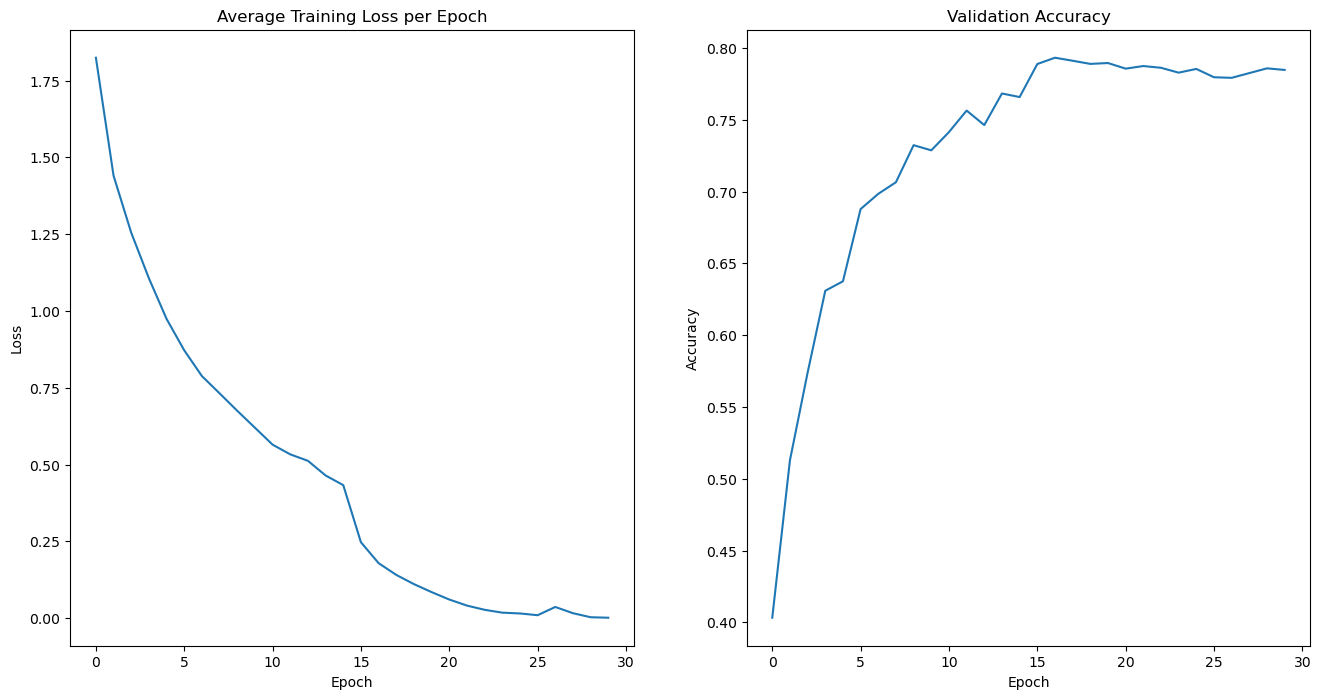

In [ ]:
num_hidden_convs = 31  # Number of hidden convolutional layers
epochs = 30
learning_rate = 0.001
model_name = 'ResCNN'  # 'MyCNN' or 'ResCNN'


dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if model_name == 'MyCNN':
    net = MyCNN(num_hidden_convs=num_hidden_convs).to(dev)
    wandb.init(project='Lab1-DLA', name=f'CNN_CIFAR10_conv-layers_{num_hidden_convs + 1}')
elif model_name == 'ResCNN':
    num_res_blocks = 16
    net = ResCNN(num_res_blocks=num_res_blocks, in_channels=3, hidden_channels=64, num_classes=10).to(dev)
    wandb.init(project='Lab1-DLA', name=f'ResCNN_CIFAR10_conv-layers_{(num_res_blocks)*2 + 1}')
else:
    raise ValueError(f'Unknown model name: {model_name}')

opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = StepLR(opt, step_size=15, gamma=0.1)



losses = []
accuracies = []

for epoch in range(epochs):
    losses.append(train_per_epoch(net, cifar_train_loader, opt, dev))
    print(f'Epoch: {epoch+1} Loss: {losses[-1]}')
    if scheduler is not None:
        scheduler.step()
    accuracies.append(evaluate(net, cifar_val_loader, dev)[0])
    print(f'Validation Accuracy: {accuracies[-1]}')
    wandb.log({
        'epoch': epoch + 1,
        'training_loss': losses[-1],
        'validation_accuracy': accuracies[-1]
    })

# Plot di training loss e validation accuracy

plot_loss_and_accuracy(losses, accuracies)

# Valutazione finale sul test set
test_accuracy, test_report = evaluate(net, cifar_test_loader, device=dev)
print(f'Test Accuracy: {test_accuracy}')

wandb.finish()


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open('./cam_samples/dog.JPEG').convert('RGB')

input_tensor = transform(img).unsqueeze(0)

resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
print(resnet)

features = []

def forward_hook(module, input, output):
    features.append(output.detach())

final_conv_layer = resnet.layer4[1].conv2

final_conv_layer.register_forward_hook(forward_hook)

class_indices = [0, 217] #classe per tench e english springer rispettivamente
weight = resnet.fc.weight.detach().cpu().numpy()

weight_subset = weight[class_indices, :]
features.clear()

resnet.eval()
out = resnet(input_tensor)

probs = F.softmax(out, dim=1)

class_idx = torch.argmax(probs).item()

feature_conv = features[0].cpu().numpy()

print(feature_conv.shape)

    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

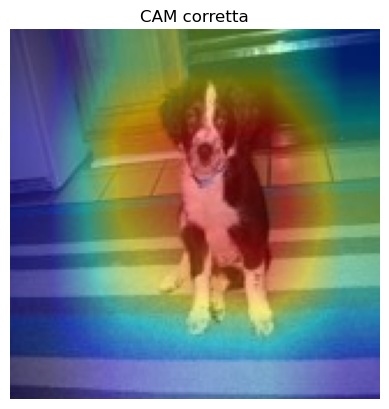

In [ ]:
import cv2

# Codice generato con l'ausilio di ChatGPT

# Funzione per generare la Class Activation Map (CAM)
def generate_CAM(conv_features, softmax_weights, class_idx=1):
    _, c, h, w = conv_features.shape
    cam = softmax_weights[1].dot(conv_features.reshape((c, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (160,160))
    return cam

cam = generate_CAM(feature_conv, weight_subset, class_idx)

# Heatmap è già normalizzata tra 0 e 1
heatmap = np.uint8(255 * cam)

# Applica colormap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Converte immagine PIL in NumPy
img_np = np.array(img.resize((160, 160)))  # (H, W, 3), RGB

# Converte heatmap da BGR → RGB per matplotlib
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Sovrapposizione
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Visualizza correttamente orientata
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("CAM")
plt.show()
